In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pomegranate import *
from scipy import stats

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine
from model.featureConfig import FeatureConfig_G3
#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

## Configuration and Data Loading

In [2]:
# Setup configuration
cfg = config.ResearchConfig_MonOnly
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:03<00:00, 671.26it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [3]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: outcome.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.
+ Add feature: mark.
Aggregate data over customer months.


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


In [4]:
ftr_list = ['num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num',
            'last_access', 
            'active',
            'usage', 'usage_complete', 'usage_incomplete', 'rate_incomplete_usage',
            'num_pass', 'num_replay', 'num_fail', 'rate_pass', 'rate_fail',
            'num_assess', 'assess', 'num_replay', 'rate_assess',
            'sum_help',
            'usage_sd2', 'num_sd2',
            'usage_sd0', 'num_sd0',
            'rate_stackDepth23_num', 'rate_stackDepth23_usage',
            'age',
            'mark_complete', 'mark_incomplete',
            'progress', 'progress_delta',
            'calendar_month',
           ]

data_engine.select_features(ftr_list)

X = data_engine.data_
y = data_engine.target_

df_whizz1 = data_engine.df_whizz_

## Groups

In [5]:
mask_churn = df_whizz1.churn==1

mask_inactive = df_whizz1.active==0

print('Churn rate for inactive subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_inactive&mask_churn].shape[0]/df_whizz1[mask_inactive].shape[0]*100))
print('Churn rate for active subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_inactive&mask_churn].shape[0]/df_whizz1[~mask_inactive].shape[0]*100))

mask_noassess = (df_whizz1.assess==0) & (df_whizz1.active==1)
print('Churn rate for subscribers having no assessment = {:.2f}%.'.\
      format(df_whizz1[mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[mask_noassess&~mask_inactive].shape[0]*100))
print('Churn rate for subscribers having assessment = {:.2f}%.'.\
      format(df_whizz1[~mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[~mask_noassess&~mask_inactive].shape[0]*100))

mask_fine = ~mask_inactive & ~mask_noassess

print('Churn rate for good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_fine&mask_churn].shape[0]/\
             df_whizz1[mask_fine].shape[0]*100))
print('Churn rate for not good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_fine&mask_churn].shape[0]/\
             df_whizz1[~mask_fine].shape[0]*100))
print('Churn rate for all subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_churn].shape[0]/\
             df_whizz1.shape[0]*100))

Churn rate for inactive subscribers = 22.99%.
Churn rate for active subscribers = 10.46%.
Churn rate for subscribers having no assessment = 16.94%.
Churn rate for subscribers having assessment = 10.21%.
Churn rate for good-quality subscribers = 10.21%.
Churn rate for not good-quality subscribers = 22.61%.
Churn rate for all subscribers = 14.96%.


## Initial Diagnostics of Features

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


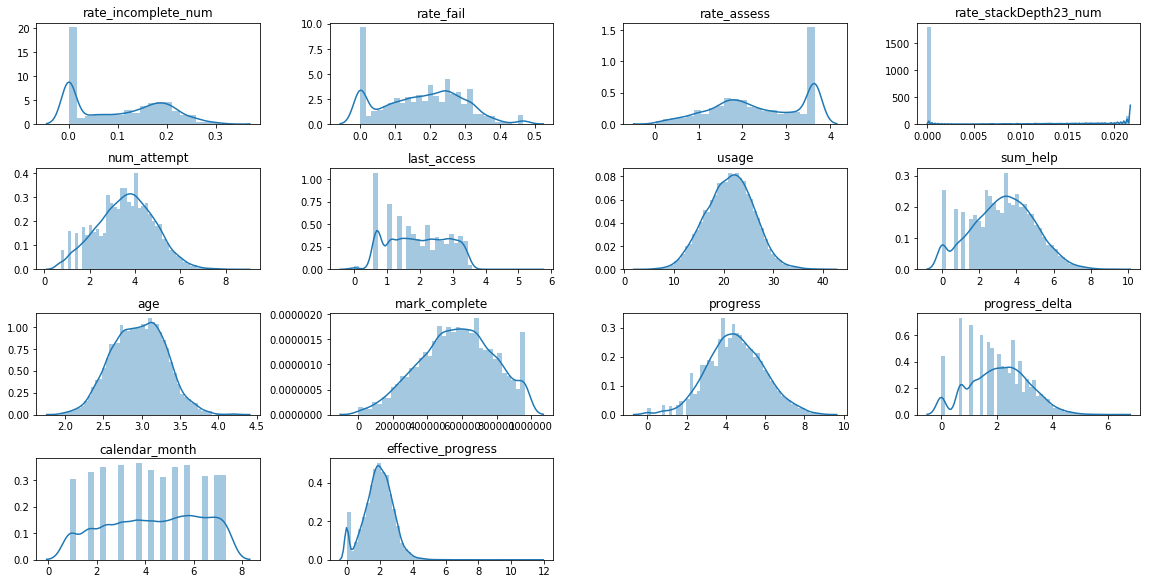

In [7]:
df_whizz_fine = df_whizz1[mask_fine]
df_whizz_fine.drop(columns=['active', 'assess', 'mark_incomplete'], inplace=True)

df_whizz_fine = df_whizz_fine.assign(effective_progress=df_whizz_fine.progress_delta/df_whizz_fine.usage*3600.)


ftr_list_independent = ['rate_incomplete_num',
                        'rate_fail',
                        'rate_assess',
                        'rate_stackDepth23_num', 
                       ]

ftr_list_multivariate = ['num_attempt',
            'last_access', 
            'usage',
            'sum_help',
            'age',
            'mark_complete',
            'progress', 'progress_delta',
            'calendar_month',
            'effective_progress'
           ]

ftr_list = ftr_list_independent + ftr_list_multivariate

ftr_list_nontransform = []
utility.plotlib.feature_distribution(
    df_whizz_fine, ftr_list, 4, cfg, 
    transform=True, ftr_list_nontransform=ftr_list_nontransform)

C:\Users\User\Anaconda3\lib\site-packages\seaborn\palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


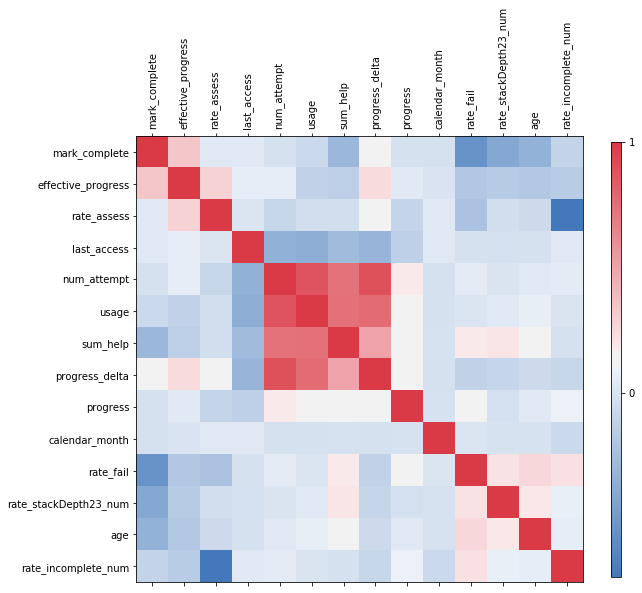

In [8]:
utility.plotlib.feature_correlation(df_whizz_fine[ftr_list])

In [9]:
def density_mixtureModel(ftr_str, x, model, hist_bin):
    
    xbin = np.arange(x.min()-(x.max()-x.min())/50., x.max()*1.1, (x.max()-x.min())/hist_bin)
    xs = np.arange(x.min()-(x.max()-x.min())/50., x.max()*1.1, (x.max()-x.min())/100.)
    prob = model.probability(xs)

    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.title(ftr_str, fontsize=12)
    plt.hist(x, bins=xbin, alpha=0.6, density=True)
    plt.plot(xs, prob, color='k')

    plt.ylabel("Density", fontsize=12); plt.yticks(fontsize=12)
    plt.xlabel("Value", fontsize=12); plt.yticks(fontsize=12)
    
def compare_transformed_singleValueRemoved(df, ftr_str, remove_point):
    series = df[ftr_str]
    x = series.values

    # Box-cox transformation
    xt,_ = stats.boxcox(x+1)
    
    # Standardise
    from sklearn.preprocessing import MinMaxScaler
    xt1 = xt.reshape(-1, 1)
    xt1 = MinMaxScaler().fit(xt1).transform(xt1)
    xt1 *= 99
    xt1 += 1
    xt = xt1.reshape(-1, 1)

    # Extract non-zero elements
    if remove_point=='min':
        x_rm = x[np.where(x!=x.min())[0].tolist()]
        xt_rm = xt[np.where(xt!=xt.min())[0].tolist()]
    else:
        x_rm = x[np.where(x!=x.max())[0].tolist()]
        xt_rm = xt[np.where(xt!=xt.max())[0].tolist()]
    
    # Plot
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(141)
    sns.distplot(x)

    ax = fig.add_subplot(142)
    sns.distplot(x_rm)

    ax = fig.add_subplot(143)
    sns.distplot(xt)

    ax = fig.add_subplot(144)
    sns.distplot(xt_rm)


In [10]:
def independent_component(ftr_str, plot=True):
    from sklearn.preprocessing import MinMaxScaler
    
    ftrConfig = FeatureConfig_G3()

    ftr_config = eval('ftrConfig.'+ftr_str)

    if plot:
        compare_transformed_singleValueRemoved(df_whizz_fine, ftr_str, 'min')
        
    # Define the data to be fitted
    x_raw = df_whizz_fine[ftr_str].values
    x = x_raw * ftr_config.multiplierPre
    x += ftr_config.shiftPre
    # Box-cox transform
    if ftr_config.bcTransform:
        xt, bc_param = stats.boxcox(x)
        x = xt
    x = x.reshape(-1,1)
    # Standardise
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    x *= 99
    x += 1
    # Post-BoxCox transform
    x *= ftr_config.multiplierPost
    x += ftr_config.shiftPost

    # Define the list of distributions to be mixed
    distribution_list = ftr_config.distributionList

    gmm = GeneralMixtureModel(distribution_list)
    print('Improvement = {}'.format(gmm.fit(x, verbose=False)))
    print('Weights = {}'.format(np.exp(gmm.weights)))

    if plot:
        density_mixtureModel(ftr_str, x, gmm, hist_bin=35)
    
    group = gmm.predict(x)
    
    return gmm, group

## Rate of number of incomplete attempts

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Improvement = 3254.9897468088457
Weights = [0.321608   0.16320731 0.4935955  0.02158919]


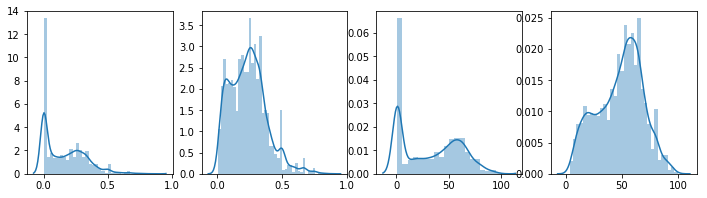

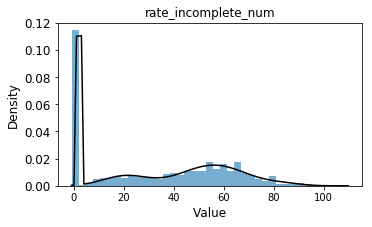

In [12]:
ftr_str = 'rate_incomplete_num'
m, g = independent_component(ftr_str)

## Rate of number of incomplete usage

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Improvement = 1911.939425399949
Weights = [0.33062329 0.14552348 0.40423172 0.11962151]


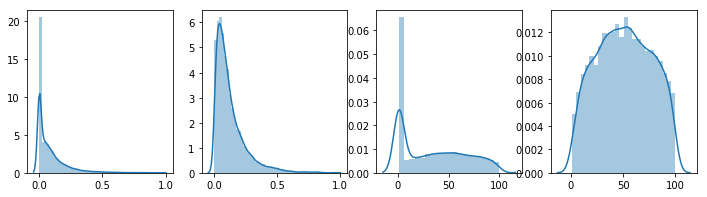

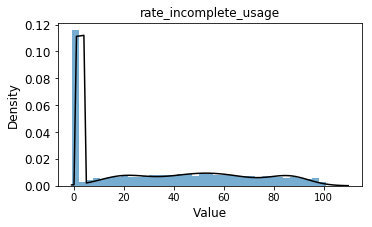

In [13]:
ftr_str = 'rate_incomplete_usage'
m, g = independent_component(ftr_str)

## Rate of fail

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Improvement = 4665.727973798836
Weights = [0.152151   0.01406478 0.26076983 0.57301439]


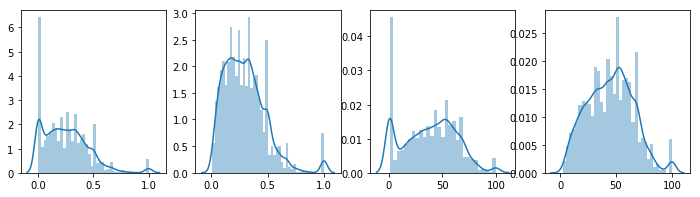

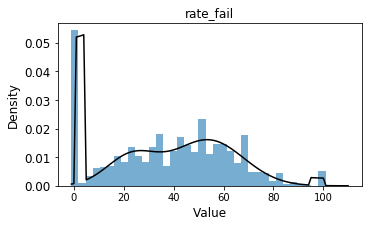

In [14]:
ftr_str = 'rate_fail'
m, g = independent_component(ftr_str)

## Rate of stack depth in 2 and 3

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Improvement = 7482.269497348127
Weights = [0.09835112 0.06319701 0.06011804 0.77833382]


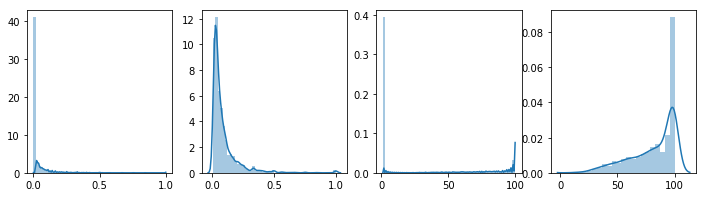

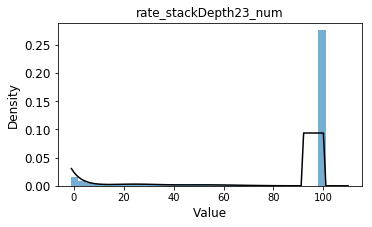

In [15]:
ftr_str = 'rate_stackDepth23_num'
m, g = independent_component(ftr_str)

## Rate of assess

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Improvement = 4782.621878518301
Weights = [0.25644716 0.11528125 0.56660471 0.06166688]


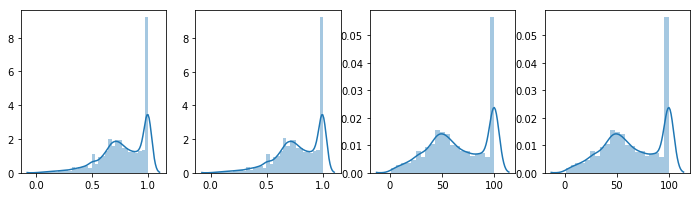

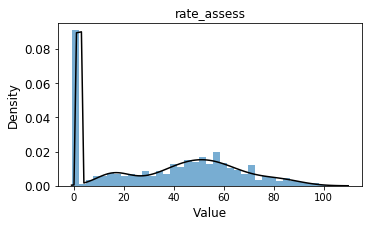

In [16]:
ftr_str = 'rate_assess'
m, g = independent_component(ftr_str)

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import mixture

X = np.array(df_whizz_fine[ftr_list_multivariate]+1)
Xt = X
for i in range(0, X.shape[1]):
    xt, _ = stats.boxcox(X[:,i])
    Xt[:, i] = xt
Xt_scaled = MinMaxScaler().fit(Xt).transform(Xt)

y = df_whizz_fine.churn.values

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Initialization 0
  Iteration 0	 time lapse 0.01795s	 ll change inf
  Iteration 100	 time lapse 0.64070s	 ll change 0.00000
Initialization converged: True	 time lapse 0.81427s	 ll 9.09750


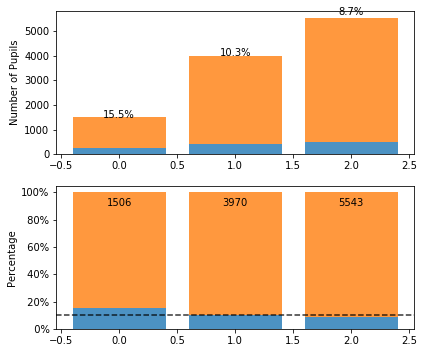

In [18]:
n_components = 3

gmm = mixture.GaussianMixture(
    n_components=n_components, 
    covariance_type='full',
    init_params='random',
    verbose=2, verbose_interval=100,
    n_init=1, 
    tol=1e-6, max_iter=1000).fit(Xt_scaled)

group_m = gmm.predict(Xt_scaled)
utility.plotlib.component_bar(y, group_m, n_components)

Initialization 0
  Iteration 0	 time lapse 0.04089s	 ll change inf
  Iteration 100	 time lapse 6.78503s	 ll change 0.00259
  Iteration 200	 time lapse 4.83812s	 ll change 0.00054
  Iteration 300	 time lapse 4.65356s	 ll change 0.00408
Initialization converged: True	 time lapse 17.18979s	 ll 190688.76829


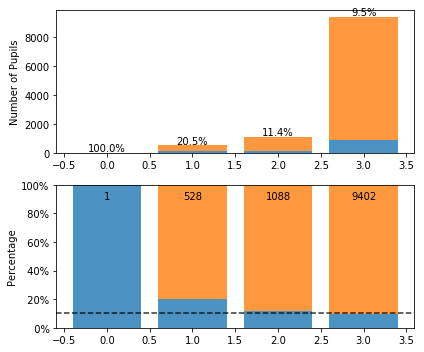

In [20]:
n_components = 10
n_features = len(ftr_list_multivariate)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-4, max_iter=10000, n_init=1, 
    verbose=2, verbose_interval=100).fit(Xt_scaled)

group_m = dpgmm.predict(Xt_scaled)

utility.plotlib.component_bar(y, group_m, n_components)

In [21]:
n_var_indep = len(ftr_list_independent)
# Combine the group assignemnts from multivariate Gaussian features and independent features
group = []
col_name = []
group.append(group_m)
col_name.append('multi')
for i_var in range(n_var_indep):
    ftr_str = ftr_list_independent[i_var]
    m, g = independent_component(ftr_str, plot=False)
    group.append(g)
    col_name.append('indep'+str(i_var))

Improvement = 3254.9897468088457
Weights = [0.321608   0.16320731 0.4935955  0.02158919]
Improvement = 4665.727973798836
Weights = [0.152151   0.01406478 0.26076983 0.57301439]
Improvement = 4782.621878518301
Weights = [0.25644716 0.11528125 0.56660471 0.06166688]
Improvement = 7482.269497348127
Weights = [0.09835112 0.06319701 0.06011804 0.77833382]


In [22]:
# Identify unique groups/labels and frequency
label = np.array(group).transpose()
unq_rows, count = np.unique(label, axis=0, return_counts=True)
map_group_count = {tuple(i):j for i,j in zip(unq_rows,count)}

In [23]:
# Compute churn rate within each group
map_group_churn = {}
for k in range(0, len(unq_rows)):
    indices = [i for i, x in enumerate(label.tolist()) if x==unq_rows[k].tolist()]
    l = y[indices]
    map_group_churn[tuple(unq_rows[k])] = l.sum()*1. / len(l)

In [24]:
# Construct the grouping data frame
df_grouping = pd.DataFrame(unq_rows, columns=col_name)
df_grouping = df_grouping.assign(count=count,
                   churn=list(map_group_churn.values()))
df_grouping.sort_values(by='churn', ascending=False, inplace=True)
df_grouping['cumcount'] = df_grouping['count'].cumsum()

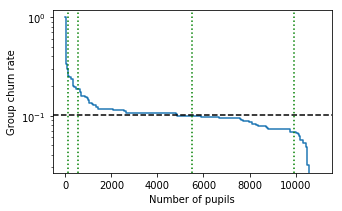

In [25]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.step(df_grouping['cumcount'].values, df_grouping['churn'].values)
ax.axhline(y=y.sum()/len(y), linestyle='--', color='k')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 1), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 5), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 50), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 90), linestyle=':', color='g')
ax.set_xlabel('Number of pupils')
ax.set_ylabel('Group churn rate')
#ax.set_xscale('log')
ax.set_yscale('log')

In [26]:
agg_anchors = [0, 1, 5, 90, 100]
num_agg = len(agg_anchors) - 1
agg_churn = []
agg_count = []
l = np.arange(0, len(y)) + 1
for i in range(len(agg_anchors)):
    if i==0:
        continue
    else:
        lower = np.percentile(l, agg_anchors[i-1])
        upper = np.percentile(l, agg_anchors[i])
    
    if i==len(agg_anchors)-1:
        mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<=upper)
    else:
        mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<upper)
        
    df_grouping.loc[mask, 'agg'] = i
    df = df_grouping[mask]
    temp = df['churn'] * df['count']
    num_churn = temp.sum()
    agg_count.append(df['count'].sum())
    agg_churn.append(num_churn*1./agg_count[i-1])

data = {'count': agg_count,
        'churn': agg_churn
    }
df_grouping_agg = pd.DataFrame(data)
df_grouping_agg['cumcount'] = df_grouping_agg['count'].cumsum()

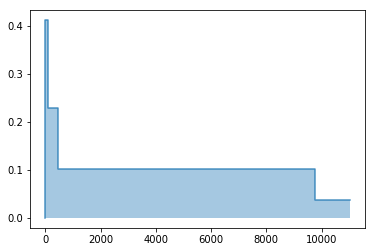

In [27]:
xp = df_grouping_agg['cumcount'].values
yp = df_grouping_agg['churn'].values

xp = np.insert(xp, 0, 0)
yp = np.insert(yp, 0, 0)

plt.fill_between(xp, yp, step='pre', alpha=0.4)
plt.plot(xp, yp, drawstyle="steps", alpha=0.8)
#plt.step(df_countchurn['cumcount'].values, df_countchurn['churn'].values, alpha=0.8)

In [28]:
df_grouping_agg

,churn,count,cumcount
0,0.411765,102,102
1,0.228324,346,448
2,0.102528,9334,9782
3,0.037995,1237,11019
